In [2]:
# from datasets import load_dataset
import pandas as pd

# https://huggingface.co/datasets/jiovine/pixel-art-nouns
df = pd.read_parquet("hf://datasets/jiovine/pixel-art-nouns/data/train-00000-of-00001-b0bd40c02bb2b37c.parquet")

df.sample(10)

,image,text
4210,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square light green glasses, a..."
46296,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square light gray glasses, a ..."
16321,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square blue glasses, a pumpki..."
35266,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square red glasses, a spaghet..."
47649,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square brown glasses, a icepo..."
41198,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square green glasses, a star-..."
12997,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square black sunglasses, a be..."
46970,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square light green glasses, a..."
9568,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square dark green glasses, a ..."
6104,{'bytes': b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\...,"a character with square black sunglasses, a pe..."


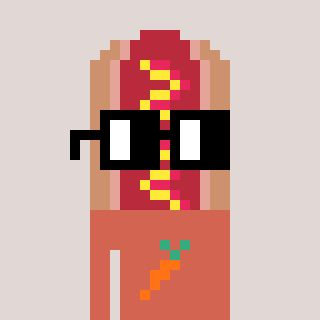

In [3]:
from PIL import Image
from typing import Any
import io
from IPython.display import display

# load the first image and display
image_data: dict[str, Any] = df['image'][0]
image_bytes: bytearray = image_data['bytes']
img = Image.open(io.BytesIO(image_bytes))
display(img)


In [5]:
from matplotlib import pyplot as plt

def get_image_from_dataset(dataset: pd.DataFrame, index: int) -> Image.Image:
    """
    Get a PIL image from a dataset at the specified index.
    
    Args:
        dataset: DataFrame containing image data
        index: Index of the image to retrieve
        
    Returns:
        PIL Image object
    """
    image_data = dataset['image'][index]
    image_bytes = image_data['bytes']
    return Image.open(io.BytesIO(image_bytes))

def viz_compare_images(img1: Image.Image, img2: Image.Image):
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img1)
    axes[0].set_title('Image 1')
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].set_title('Image 2')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

def scale_image(image: Image.Image, factor: float) -> Image.Image | None:
    """Scales a PIL Image down by a factor and returns a new PIL Image.

    Args:
        image: The PIL Image to scale.
        factor: The scaling factor (e.g., 0.5 for half the size).

    Returns:
        A new PIL Image scaled down by the factor, or None if an error occurs.
    """
    try:
        width, height = image.size
        new_width = int(width * factor)
        new_height = int(height * factor)
        scaled_image = image.resize((new_width, new_height), resample=Image.Resampling.NEAREST)
        return scaled_image
    except Exception as e:
        print(f"Error scaling image: {e}")
        return None

In [12]:
from tqdm import tqdm
import ipywidgets as widgets

df_sample = df.sample(40)

def analyze_image_quality(scale: int) -> bool:
    n_good = 0
    n_bad = 0
    image_shown = False
    for i, _ in tqdm(df_sample.iterrows()):
        image = get_image_from_dataset(df_sample, i)
        scaled_down_image = scale_image(image, 1/scale)
        scaled_back_up_image = scale_image(scaled_down_image, scale)
        if image.tobytes() == scaled_back_up_image.tobytes():
            n_good += 1
        else:
            n_bad += 1
        if not image_shown:
            viz_compare_images(image, scaled_back_up_image)
            image_shown = True
    print(f"n_good: {n_good}")
    print(f"n_bad: {n_bad}")

image_slider = widgets.IntSlider(
    min=1,
    max=100,
    step=1,
    description='Scale:',
    value=1
)

widgets.interactive(analyze_image_quality, scale=image_slider)

interactive(children=(IntSlider(value=1, description='Scale:', min=1), Output()), _dom_classes=('widget-intera…

Original Image Size: (320, 320)
Scaled Down Image Size: (32, 32)


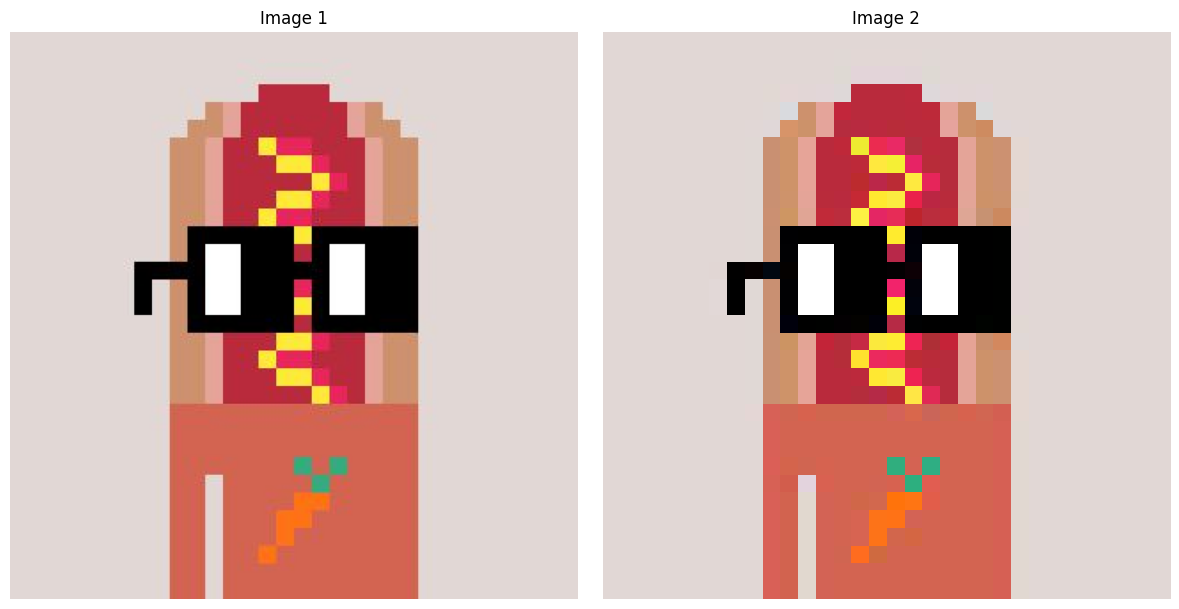

<Figure size 640x480 with 0 Axes>

In [16]:
# Get the first image from the dataset and scale it down
first_image_idx = df.index[0]  # Get the index of the first image
first_image = get_image_from_dataset(df, first_image_idx)

# Scale down by a factor of 10
scale_factor = 10
scaled_down_image = scale_image(first_image, 1/scale_factor)

# Display original and scaled images
print("Original Image Size:", first_image.size)
print("Scaled Down Image Size:", scaled_down_image.size)

viz_compare_images(first_image, scaled_down_image)

plt.tight_layout()
plt.show()


## Takeaways
- Images are all portraits of characters, all in the same pose, so could be useful for training a game pixelart diffusion model if you want to generate a range of characters.
- The images are all 10x10 pixels, and would need to be downscaled by 1/10 as pre-processing for training.
- Some artifacts exist in the dataset images, so these may transfer when downscaling to 1x1 pixelsize.